In [51]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [52]:
def prepare_data(df):
    """
    Prepare the data for modeling by creating necessary features and encoding
    """
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
        
    # Create copy of DataFrame with date as column for Prophet
    df = df.copy()
    df['date'] = df.index
    
    # Create time-based features
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    
    # Create seasonality features
    df['quarter'] = df.index.quarter
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # One-hot encode day_of_week if it exists as categorical
    if 'day_of_week' in df.columns and df['day_of_week'].dtype == 'O':
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        day_of_week_encoded = encoder.fit_transform(df[['day_of_week']])
        day_of_week_cols = [f'day_{i}' for i in range(day_of_week_encoded.shape[1])]
        df[day_of_week_cols] = day_of_week_encoded
        df.drop('day_of_week', axis=1, inplace=True)
        
    # Convert is_holiday to numeric if it isn't already
    if 'is_holiday' in df.columns and df['is_holiday'].dtype == 'O':
        df['is_holiday'] = df['is_holiday'].astype(int)
    return df

In [53]:
def create_recurring_holidays(df):
    """
    Create a DataFrame of recurring holidays from historical data
    """
    # Get dates that are holidays
    holiday_dates = df[df['is_holiday'] == 1]['date']
    # Extract month and day for each holiday
    holiday_patterns = pd.DataFrame({
    'month': holiday_dates.dt.month,
    'day': holiday_dates.dt.day
    }).drop_duplicates()
    # Create holidays for the forecast period
    last_date = df.index.max()
    forecast_end = last_date + pd.DateOffset(months=4) # Add buffer for forecast period
    all_holidays = []
    for year in range(df.index.min().year, forecast_end.year + 1):
        for _, holiday in holiday_patterns.iterrows():
            try:
                holiday_date = pd.Timestamp(year=year, month=holiday['month'], day=holiday['day'])
                all_holidays.append(holiday_date)
            except ValueError:
                continue # Skip invalid dates (e.g., Feb 29 in non-leap years)
    holidays_df = pd.DataFrame({
        'ds': all_holidays,
        'holiday': 'recurring_holiday',
        'lower_window': 0,
        'upper_window': 0
        })
    return holidays_df

In [54]:
def train_prophet_model(df):
    """
    Train a Prophet model with enhanced seasonality
    """
    # Prepare data for Prophet
    prophet_df = df[['date', 'total_calls']].rename(columns={
        'date': 'ds',
        'total_calls': 'y'
        })

    # Create holidays DataFrame
    if 'is_holiday' in df.columns:
        holidays_df = create_recurring_holidays(df)
    else:
        holidays_df = None
    # Initialize Prophet with detailed seasonality
    model = Prophet(
        yearly_seasonality=20, # More complex yearly seasonality
        weekly_seasonality=7, # Detailed weekly patterns
        daily_seasonality=True,
        holidays=holidays_df, # Add our recurring holidays
        holidays_prior_scale=10, # Increase impact of holidays
        seasonality_prior_scale=10,
        seasonality_mode='multiplicative' # Often better for call center data
    )
    # Add custom seasonalities
    model.add_seasonality(
        name='quarterly',
        period=365.25/4,
        fourier_order=5
    )
    model.fit(prophet_df)
    return model

In [55]:
def train_xgboost_model(df):
    """
    Train an XGBoost model using enhanced features
    """
    # Ensure 'date' column is converted to timestamp
    if 'date' in df.columns:
        df['date'] = df['date'].apply(lambda x: x.timestamp())
    
    # Prepare features
    feature_cols = df.columns.tolist()
    
    # Remove target column from features
    feature_cols.remove('total_calls')
    
    X = df[feature_cols]
    y = df['total_calls']
        
    # Train XGBoost with parameters tuned for time series
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X, y)
    return model, feature_cols

In [56]:
def generate_future_dates(last_date, periods):
    """
    Generate future dates for prediction
    """
    future_dates = pd.date_range(
        start=last_date + timedelta(days=1),
        periods=periods,
        freq='D'
    )
    return future_dates

In [57]:
def make_predictions(df, forecast_days=90):
    """
    Make predictions using both Prophet and XGBoost models
    """
    # Prepare data with enhanced features
    df_prepared = prepare_data(df)
    
    # Train Prophet model
    prophet_model = train_prophet_model(df_prepared)
    
    # Generate future dates for Prophet
    future_dates = generate_future_dates(df_prepared['date'].max(), forecast_days)
    future_df = pd.DataFrame({'ds': future_dates})
    
    # Make Prophet predictions
    prophet_forecast = prophet_model.predict(future_df)
    
    # Train XGBoost model
    xgb_model, feature_cols = train_xgboost_model(df_prepared)
    
    # Prepare future data for XGBoost
    future_features = pd.DataFrame(index=future_dates)
    future_features['date'] = future_dates
    future_features['month'] = future_dates.month
    future_features['year'] = future_dates.year
    future_features['day_of_month'] = future_dates.day
    future_features['week_of_year'] = future_dates.isocalendar().week
    future_features['quarter'] = future_dates.quarter
    future_features['month_sin'] = np.sin(2 * np.pi * future_dates.month / 12)
    future_features['month_cos'] = np.cos(2 * np.pi * future_dates.month / 12)
    future_features['day_of_week_sin'] = np.sin(2 * np.pi * future_dates.dayofweek / 7)
    future_features['day_of_week_cos'] = np.cos(2 * np.pi * future_dates.dayofweek / 7)
    
    # Define Armenian holidays 
    armenian_holidays = [
        '2022-01-01','2023-01-01','2024-01-01','2025-01-01','2026-01-01',
        '2022-01-02','2023-01-02','2024-01-02','2025-01-02','2026-01-02',
        '2022-01-06','2023-01-06','2024-01-06','2025-01-06','2026-01-06',
        '2022-01-28','2023-01-28','2024-01-28','2025-01-28','2026-01-28',
        '2022-03-08','2023-03-08','2024-03-08','2025-03-08','2026-03-08',
        '2022-04-24','2023-04-24','2024-04-24','2025-04-24','2026-04-24',
        '2022-05-01','2023-05-01','2024-05-01','2025-05-01','2026-05-01',
        '2022-05-09','2023-05-09','2024-05-09','2025-05-09','2026-05-09',
        '2022-05-28','2023-05-28','2024-05-28','2025-05-28','2026-05-28',
        '2022-07-05','2023-07-05','2024-07-05','2025-07-05','2026-07-05',
        '2022-09-21','2023-09-21','2024-09-21','2025-09-21','2026-09-21',
        '2022-12-31','2023-12-31','2024-12-31','2025-12-31','2026-12-31',
    ]

    armenian_holidays = pd.to_datetime(armenian_holidays)
    # Add a column to indicate if the date is a holiday
    future_features["is_holiday"] = future_features.index.isin(armenian_holidays)
    
    # Add additional features if available
    additional_features = [
        'working_time', 'number_of_unique_logins','clients',
        'answered_calls', 'missed_calls', 'unique_numbers', 'Call duration',
        'time_to_next_call', 'calls_from_clients', 'share_of_answered_calls',
        'share_of_calls_from_registered_number', 'number_of_new_clients',
        'number_of_new_clients_last_7_days', 'number_of_new_clients_last_30_days'
    ]
    
    df['date'] = df.index
    # Predict using Prophet model for each additional feature
    for feature in additional_features:
        if feature in df.columns:
            prophet_df = df[['date', feature]].rename(columns={
                'date': 'ds',
                feature: 'y'
                })

            # Create holidays DataFrame
            if 'is_holiday' in df.columns:
                holidays_df = create_recurring_holidays(future_features)
            else:
                holidays_df = None
            # Initialize Prophet with detailed seasonality
            model = Prophet(
                yearly_seasonality=20, # More complex yearly seasonality
                weekly_seasonality=7, # Detailed weekly patterns
                daily_seasonality=True,
                holidays=holidays_df, # Add our recurring holidays
                holidays_prior_scale=10, # Increase impact of holidays
                seasonality_prior_scale=10,
                seasonality_mode='multiplicative' # Often better for call center data
            )
            # Add custom seasonalities
            model.add_seasonality(
                name='quarterly',
                period=365.25/4,
                fourier_order=5
            )
            model.fit(prophet_df)

            future_feature_forecast = model.predict(future_df)
            future_features[feature] = future_feature_forecast['yhat'].to_list()


    # Add one-hot encoded day of week if present in training data
    day_cols = [col for col in feature_cols if col.startswith('day_') and col != 'day_of_month']
    if day_cols:
        for col in day_cols:
            future_features[col] = 0
        for i, date in enumerate(future_dates):
            day_num = date.dayofweek
            if f'day_{day_num}' in day_cols:
                future_features.loc[future_features.index[i], f'day_{day_num}'] = 1
    
    # Convert 'date' column to timestamp
    future_features['date'] = future_features['date'].apply(lambda x: x.timestamp())
    


    # Make XGBoost predictions
    xgb_forecast = xgb_model.predict(future_features[feature_cols])
    
    # Combine predictions with weighted ensemble
    # Give more weight to Prophet for longer-term predictions
    weights = np.linspace(0.4, 0.6, forecast_days)  # Gradually increase Prophet's weight
    final_forecast = pd.DataFrame({
        'date': future_dates,
        'prophet_forecast': prophet_forecast['yhat'],
        'xgboost_forecast': xgb_forecast,
        'ensemble_forecast': weights * prophet_forecast['yhat'] + (1 - weights) * xgb_forecast
    })
    
    return final_forecast

In [58]:
def evaluate_models(df):
    """
    Evaluate model performance using historical data
    """
    # Use last 30 days as test set
    test_size = 30
    train_df = df[:-test_size]
    test_df = df[-test_size:]
    
    # Make predictions
    forecast = make_predictions(train_df, forecast_days=test_size)
    
    # Calculate metrics
    actual_values = test_df['total_calls'].values
    predicted_values = forecast['ensemble_forecast'].values
    
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    return mae, rmse, mape

In [59]:
# Load data
df = pd.read_excel('calls.xlsx', parse_dates=['Date'], index_col='Date')
df = df.sort_index()
df = df.drop(columns=['Unnamed: 0'])

In [60]:
df["day_of_week"] = df.index.day_name()

In [61]:
# Define Armenian holidays 
armenian_holidays = [
    '2022-01-01','2023-01-01','2024-01-01','2025-01-01','2026-01-01',
    '2022-01-02','2023-01-02','2024-01-02','2025-01-02','2026-01-02',
    '2022-01-06','2023-01-06','2024-01-06','2025-01-06','2026-01-06',
    '2022-01-28','2023-01-28','2024-01-28','2025-01-28','2026-01-28',
    '2022-03-08','2023-03-08','2024-03-08','2025-03-08','2026-03-08',
    '2022-04-24','2023-04-24','2024-04-24','2025-04-24','2026-04-24',
    '2022-05-01','2023-05-01','2024-05-01','2025-05-01','2026-05-01',
    '2022-05-09','2023-05-09','2024-05-09','2025-05-09','2026-05-09',
    '2022-05-28','2023-05-28','2024-05-28','2025-05-28','2026-05-28',
    '2022-07-05','2023-07-05','2024-07-05','2025-07-05','2026-07-05',
    '2022-09-21','2023-09-21','2024-09-21','2025-09-21','2026-09-21',
    '2022-12-31','2023-12-31','2024-12-31','2025-12-31','2026-12-31',
]
armenian_holidays = pd.to_datetime(armenian_holidays)
# Add a column to indicate if the date is a holiday
df["is_holiday"] = df.index.isin(armenian_holidays)

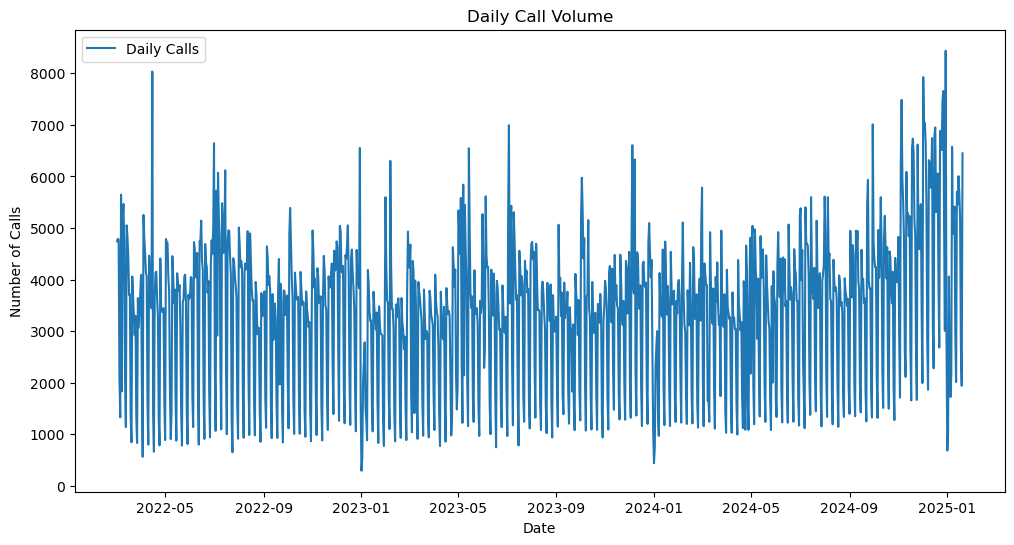

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(df['total_calls'], label='Daily Calls')
plt.title('Daily Call Volume')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

In [63]:
df.index = pd.to_datetime(df.index)

In [64]:
# df.tail(10)

In [65]:
# Assuming your data is in a pandas DataFrame called 'df' with a datetime index
results = make_predictions(df, forecast_days=90)
mae, rmse, mape = evaluate_models(df)
print(f"Model Performance Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

20:55:13 - cmdstanpy - INFO - Chain [1] start processing
20:55:13 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] start processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] done processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:17 - cmdstanpy - INFO - Chain [1] done processing
20:55:17 - cmdstanpy - INFO - Chain [1] start processing
20:55:18 - cmdstanpy - INFO - Chain [1] done processing
20:55:18 - cmdstanpy - INFO - Chain [1] start processing
20:55:18 - cmdstanpy - INFO - Chain [1] done processing
20:55:19 - cmdstanpy - INFO - Chain [1] start processing
20:55:19 - cmdstanpy - INFO - Chain [1] done processing
20:55:19 - cmdstanpy - INFO - Chain [1] start processing
20:55:19 - cmdstanpy - INFO - Chain [1] done processing
20:55:19 - cmdstanpy - INFO - Chain [1] start processing
20:55:20 - cmdstanpy - INFO - Chain [1]

Model Performance Metrics:
MAE: 841.91
RMSE: 1120.02
MAPE: 30.56%


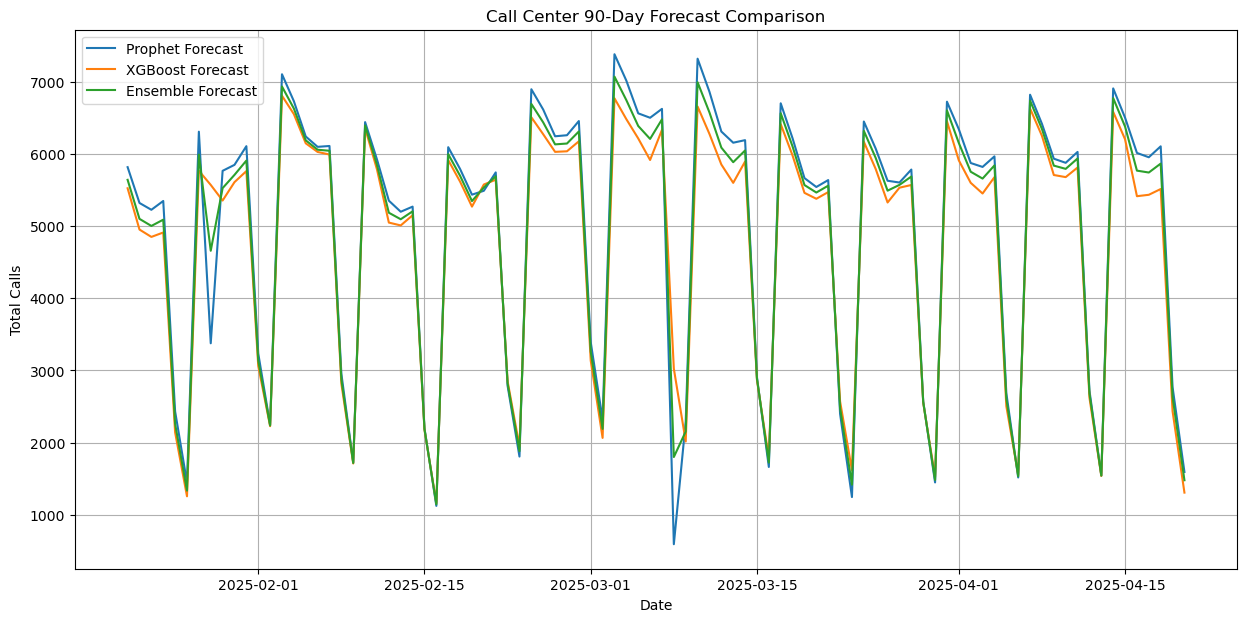

In [66]:
plt.figure(figsize=(15, 7))
plt.plot(results['date'], results['prophet_forecast'], label='Prophet Forecast')
plt.plot(results['date'], results['xgboost_forecast'], label='XGBoost Forecast')
plt.plot(results['date'], results['ensemble_forecast'], label='Ensemble Forecast')
plt.title('Call Center 90-Day Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.legend()
plt.grid(True)
plt.show()

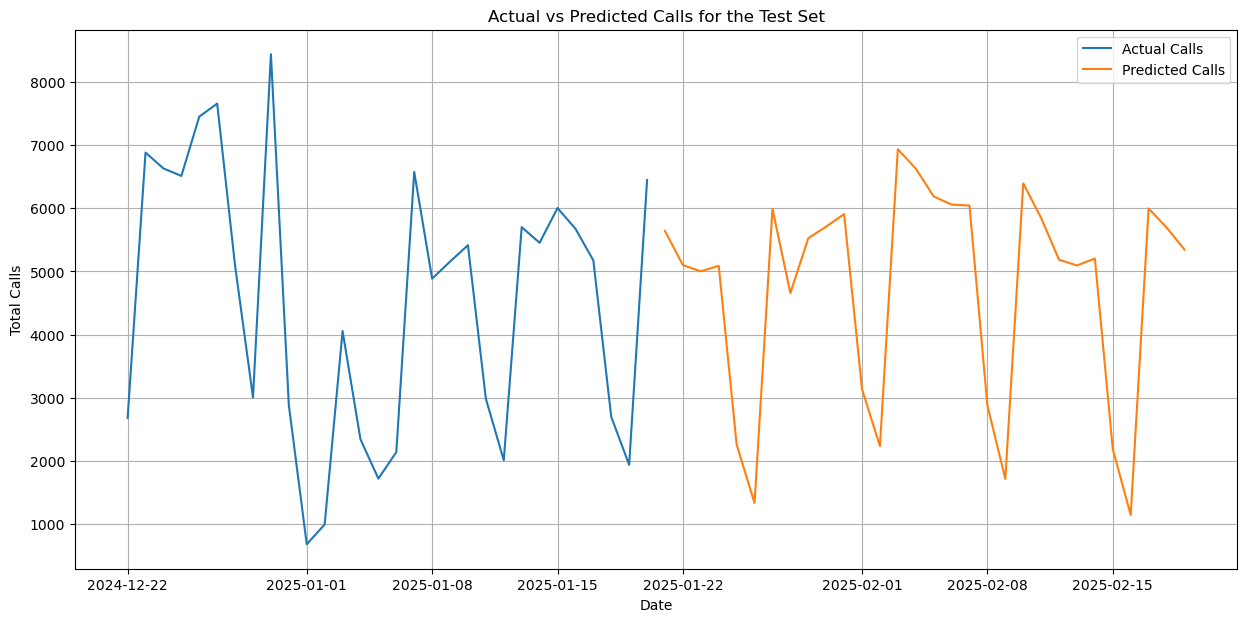

In [80]:
# Plot actual vs predicted values for the test set
plt.figure(figsize=(15, 7))
plt.plot(df.index[-30:], df['total_calls'][-30:], label='Actual Calls')
plt.plot(results['date'][:30], results['ensemble_forecast'][:30], label='Predicted Calls')
plt.title('Actual vs Predicted Calls for the Test Set')
plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
results

,date,prophet_forecast,xgboost_forecast,ensemble_forecast
0,2025-01-21,5816.144086,5523.818848,5640.748943
1,2025-01-22,5320.131469,4951.832031,5099.979445
2,2025-01-23,5225.721240,4850.023438,5001.991088
3,2025-01-24,5347.724113,4911.123535,5088.707141
4,2025-01-25,2433.048318,2142.980225,2261.614816
...,...,...,...,...
85,2025-04-16,6013.234068,5413.853516,5768.094157
86,2025-04-17,5953.315187,5433.445312,5741.862497
87,2025-04-18,6104.657830,5513.240234,5865.432735
88,2025-04-19,2769.275883,2436.033203,2635.229951


In [75]:
results['ensemble_forecast'][:30].sum()

142140.12695208864

In [76]:
results['ensemble_forecast'][30:60].sum()

155391.56920922798

In [77]:
results['ensemble_forecast'][60:].sum()

140620.08898488517

In [69]:
results.to_csv("results.csv", index=False)